## Data Analysis

In [1]:
import sys
# This line adds the src directory to the path.

## Load data into PySpark

In [2]:
%%time
"""Load data from a file and convert it to a PySpark DataFrame."""

FILE_PATH = "../../amz_products_small.jsonl.gz"
sys.path.append(
    "../"
)  # Adjusts path to include the parent directory where data_pipeline is located
from data.utils import load_jsonl_gz  # noqa: E402

df = load_jsonl_gz(FILE_PATH)

25/01/26 01:22:12 WARN Utils: Your hostname, joseLaptop resolves to a loopback address: 127.0.1.1; using 192.168.1.134 instead (on interface wlan0)
25/01/26 01:22:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/26 01:22:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


CPU times: user 3.46 s, sys: 32.5 ms, total: 3.49 s
Wall time: 13.5 s


In [3]:
data_size = df.count()
print(f"Total data size: {data_size}")
distinct_categories_count = df.select("main_cat").distinct().count()
print(f"Total distinct main categories: {distinct_categories_count}")

print(df.groupBy("main_cat").count())

Total data size: 1248417


Total distinct main categories: 22
DataFrame[main_cat: string, count: bigint]


## Plots

/tmp/ipykernel_434059/2211235104.py:13: FutureWarning:                          

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='count', y='main_cat', data=pdf, palette='hsv')


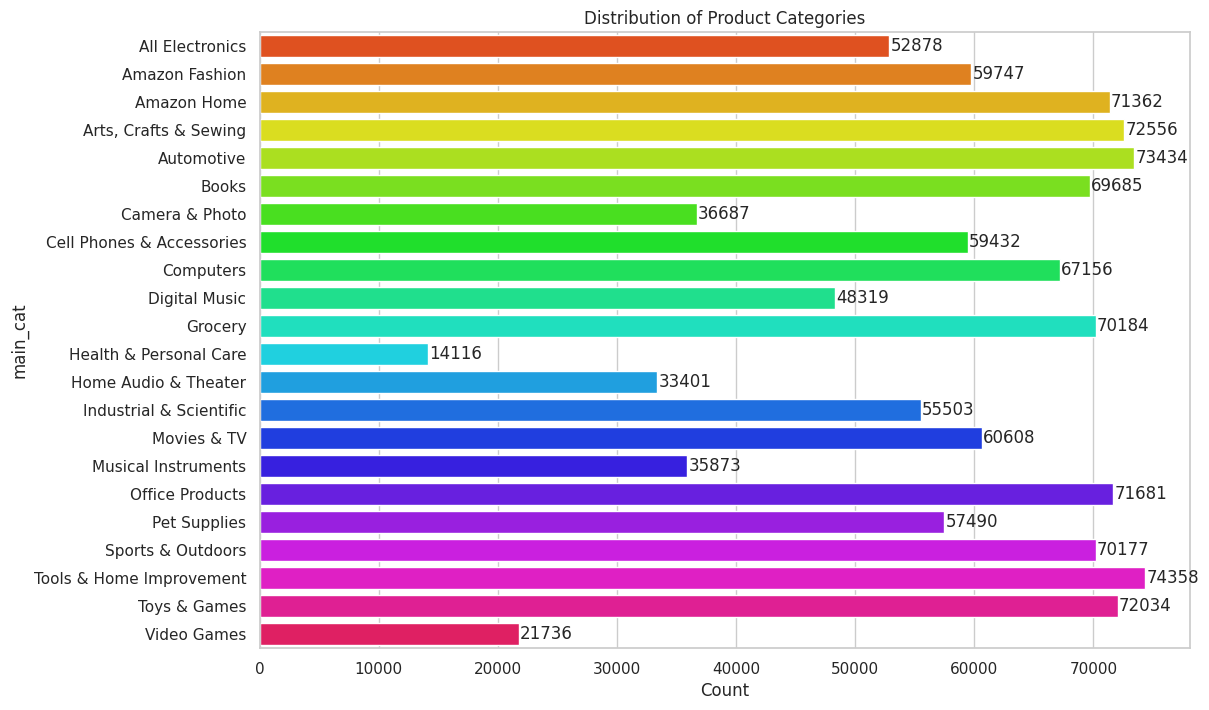

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

category_counts = df.groupBy("main_cat").count().orderBy("main_cat")
pdf = category_counts.toPandas()

# Setting the style
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x="count", y="main_cat", data=pdf, palette="hsv")

# Annotate each bar
for p in ax.patches:
    ax.annotate(
        format(p.get_width(), ".0f"),
        (p.get_width(), p.get_y() + p.get_height() / 2),
        ha="center",
        va="center",
        xytext=(20, 0),
        textcoords="offset points",
    )

# Set labels and title
plt.xlabel("Count")
plt.title("Distribution of Product Categories")

# Show plot
plt.show()

## Text length

/tmp/ipykernel_434059/1564920402.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(words_lists, labels=categories)


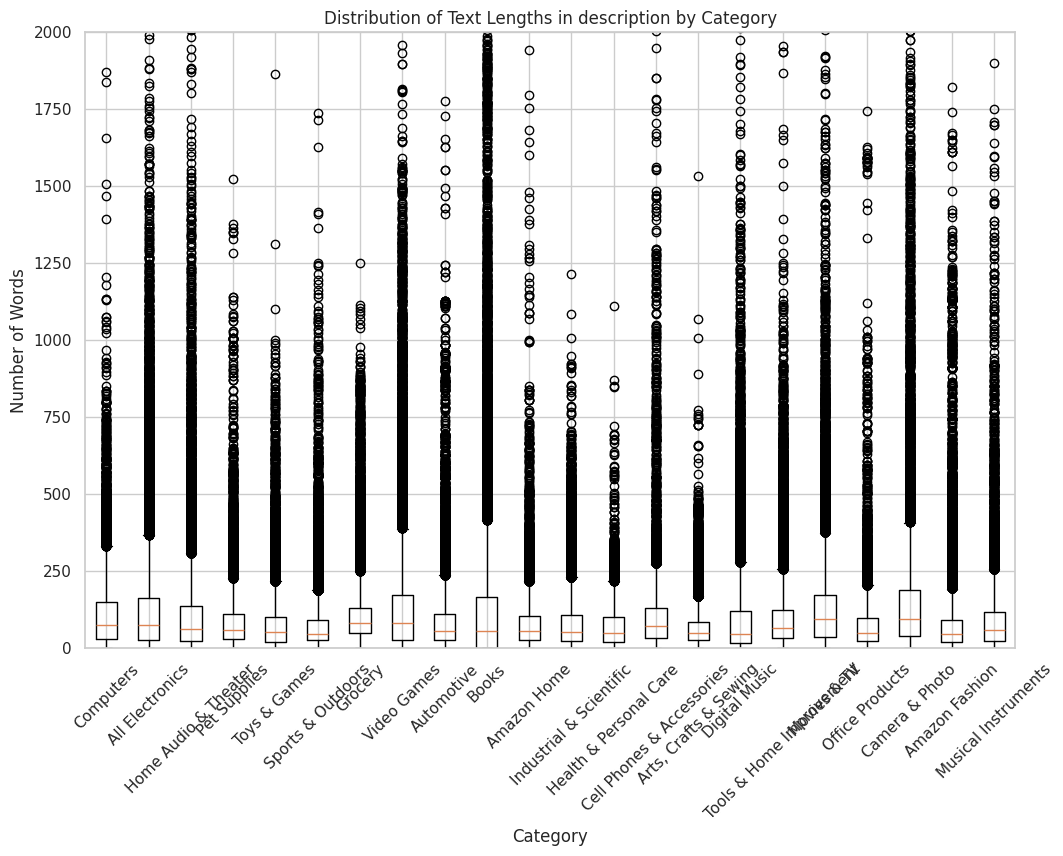

In [12]:
from pyspark.sql.functions import col, udf, collect_list
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt


# Define a UDF to calculate the total number of words in a list of strings
def count_words(text_list):
    if isinstance(text_list, list):
        # Join all strings in the list and count words
        return sum(len(text.split()) for text in text_list)
    return 0  # Return 0 if the input is not a list


count_words_udf = udf(count_words, IntegerType())


df = df.withColumn("num_words", count_words_udf(col("description")))


data_to_plot = (
    df.groupBy("main_cat")
    .agg(collect_list("num_words").alias("words_per_cat"))
    .collect()
)


# Prepare data for plotting
categories = [row["main_cat"] for row in data_to_plot]
words_lists = [row["words_per_cat"] for row in data_to_plot]

# Step 4: Creating the box plot
plt.figure(figsize=(12, 8))
plt.boxplot(words_lists, labels=categories)
plt.title("Distribution of Text Lengths in description by Category")
plt.xlabel("Category")
plt.ylabel("Number of Words")
plt.ylim(0, 2000)
plt.xticks(rotation=45)  # Rotate category labels for better readability
plt.grid(True)
plt.show()

In [13]:
from pyspark.sql.functions import avg

# Calculate the average number of words per category
average_words_per_category = df.groupBy("main_cat").agg(
    avg("num_words").alias("average_num_words")
)

# Collect the results to display
average_words_per_category_result = average_words_per_category.collect()

# Convert to a readable format for display
average_words_per_category_dict = {
    row["main_cat"]: row["average_num_words"]
    for row in average_words_per_category_result
}

# Print the results
for category, avg_words in average_words_per_category_dict.items():
    print(f"Category: {category}, Average Number of Words: {avg_words:.2f}")

Category: Computers, Average Number of Words: 101.87
Category: All Electronics, Average Number of Words: 123.96
Category: Home Audio & Theater, Average Number of Words: 108.62
Category: Pet Supplies, Average Number of Words: 85.60
Category: Toys & Games, Average Number of Words: 73.51
Category: Sports & Outdoors, Average Number of Words: 71.92
Category: Grocery, Average Number of Words: 105.62
Category: Video Games, Average Number of Words: 147.76
Category: Automotive, Average Number of Words: 85.32
Category: Books, Average Number of Words: 130.08
Category: Amazon Home, Average Number of Words: 78.63
Category: Industrial & Scientific, Average Number of Words: 83.21
Category: Health & Personal Care, Average Number of Words: 75.21
Category: Cell Phones & Accessories, Average Number of Words: 95.69
Category: Arts, Crafts & Sewing, Average Number of Words: 67.63
Category: Digital Music, Average Number of Words: 91.70
Category: Tools & Home Improvement, Average Number of Words: 92.79
Catego